## Global Imports

In [43]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pprint import pprint
from sklearn.pipeline import TransformerMixin,Pipeline,FeatureUnion,make_pipeline,make_union
from sklearn.base import BaseEstimator
from sklearn.preprocessing import LabelEncoder,FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from IPython.display import IFrame
from sklearn.model_selection import RandomizedSearchCV,validation_curve
from pprint import pprint

sns.set()


def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

def show_url(url:str):
    IFrame(url, width=800, height=450)

In [2]:
raw_train_data = pd.read_csv('data/train.csv')
print(f'Train Dataset size = {raw_train_data.shape[0]}')
raw_test_data = pd.read_csv('data/test.csv')
print(f'Test Dataset size = {raw_test_data.shape[0]}')
IDS = raw_test_data.Id

# Convert SalePrice to log value
raw_train_data.SalePrice = np.log(raw_train_data.SalePrice)

Train Dataset size = 1460
Test Dataset size = 1459


## Creating Pipeline

+ Pipelines solves some major issues relating pre-processing data for consumption of model. Often we end up with notebooks which have messy structure for preprocessing, in worst case we might end up leaking our data, as its a common pratice to merge train and test data to simplify preprocessing - This strategy isn't scalable, and falls apart fairly quick.

+ Our pipeline will manage continuous as well as categorical data, We indend to, 
    - encoding categorical data 
    - optionally provide One Hot Encoding (not implemented yet)
    - Treat missing values
        - For categorical, use most repeated values or simply replace them with a comman label
        - For Continuous, either use median value
    - And more, but this notebook will restrict to most common preprocessing steps.

#### Overview

+ Our **Final Pipeline**, will consist of a **Feature Union** which would compose **Continuous and Categorical Pipelines**.


### Creating Custom Transformers

---

#### We create following transformers:

+ **CategoricalDataFilter**
    - retrieving Categorical features

+ **ContinuousDataFilter**
    - retrieving Continuous feature

+ **CategoricalMapper**
    - encoding categorical feature values to integer space

+ **MedianImputer**
    - filling missing features with median values of each feature.
    
---

#### Why we need custom transformer?

Custom Transformer allow us to store feature specific values during fit, these can be used in transform and eventually this will ensure that data leak does not occur. 

Eg. We use median values extracted from data which is used for fitting, and use the same in transforming


#### Note: We have used **FunctionTransformer**, basically its a convinence function in which we don't have to provide logic for fit, we can tranform the data and return the transformed data, it would act just like a custom transformer.

In [3]:
class CategoricalDataFilter(TransformerMixin,BaseEstimator):
    """Transformer for extracting categorical features, based on number of unique values present in a feature"""
    
    def __init__(self,max_unique=26):
        """
            Parameters:
            ----------
            max_unique: maximum unique values permissable for feature to be considered as Categorical feature 
        """        
        self.max_unique = max_unique        
        # capture categorical feature names, return these features in transform.
        self.categorical_features = []
        
    def fit(self,X,y=None):                
        assert type(X) == pd.DataFrame

        for feature in X.columns:
            n_unique = X[feature].nunique()
            # Categorical Feature only if n_unqiue is less then max_unique
            if n_unique <= self.max_unique: 
                self.categorical_features.append(feature)        
        
        return self
    
    def transform(self,X,y=None):        
        return X[self.categorical_features]
        

class ContinuousDataFilter(BaseEstimator,TransformerMixin):
    """
        Transformer for extracting continuous features, based on number of unique values present in a feature
    """
        
    def __init__(self,min_unique=26):  
        """
            parameters:
            -----------
            min_unique: minimum number of unique values a feature should have to be considered continuous type
        """
        self.min_unique = min_unique        
        self.continuous_features = []
        
    def fit(self,X,y=None):                
        assert type(X) == pd.DataFrame

        for feature in X.columns:
            n_unique = X[feature].nunique()
            if n_unique > self.min_unique:
                self.continuous_features.append(feature)        
        
        return self
    
    def transform(self,X,y=None):        
        return X[self.continuous_features].astype('category')        
    
        

    
    
    
cat_df = CategoricalDataFilter().fit(raw_train_data).transform(raw_train_data)

cont_df = ContinuousDataFilter().fit(raw_train_data).transform(raw_train_data)

print(f'Number of Categorical Features: {len(cat_df.columns)}')
display(cat_df.columns)

print(f'Number of Continuous Features: {len(cont_df.columns)}')
display(cont_df.columns)


Number of Categorical Features: 61


Index(['MSSubClass', 'MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour',
       'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', 'LowQualFinSF', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageCars', 'GarageQual',
       'GarageCond', 'PavedDrive', '3SsnPorch', 'PoolArea', 'PoolQC', 'Fence',
       'MiscFeature', 'MiscVal', 'MoSold', 'YrSold', 'SaleType',
       'SaleCondition'],
      dtype='object')

Number of Continuous Features: 20


Index(['Id', 'LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd',
       'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
       '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'GarageYrBlt', 'GarageArea',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', 'ScreenPorch',
       'SalePrice'],
      dtype='object')

In [4]:
class CategoricalMapper(BaseEstimator,TransformerMixin):
    """
        Transformer for handling categorical value mapping, It ensures that the categories found in 
        fitting are only used for transforming, hence avoiding data leak. 
        
        Any new feature value found in transform would be mapped to 'unkown' i.e. -1 nominal value
    """
    def __init__(self):        
        
        # Preserve the mapping from feature values to encoded values.
        self.label_encoders = {}        
        
        
    def fit(self,X,y=None):        
        """ Encode the feature values"""
        assert type(X) == pd.DataFrame
        

        for feature in X:        
            feature_values = X[feature].value_counts().index.values
            label_dict = dict()
            for idx,label in enumerate(feature_values): 
                label_dict[label] = idx
            label_dict['unkown'] = -1 
            self.label_encoders[feature] = label_dict

        return self
    
    def transform(self,X,y=None):
        assert type(X) == pd.DataFrame
        X_copy = X.copy()
        for feature_name in X.columns:
            encoder = self.label_encoders[feature_name]
            for v in X[feature_name].value_counts().index.values:
                if(v not in encoder.keys()):
                    X_copy.replace(v,-1,inplace=True)
                else:
                    X_copy.replace(v,encoder[v],inplace=True)
        return X_copy
            
def FillNaWithMissing(X):    
    """
        Applicable only on categorical data.
        
        Replace 'na' values with 'missing' string, application only for categorical variables
    """
    res = X.copy()
    for fn in X.columns:    
        res[fn] = X[fn].astype('object').fillna('Missing')
    return res


CategoricalMapper().fit_transform(FillNaWithMissing(cat_df))


,MSSubClass,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,...,3SsnPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,7,5,5,5,5,5,5,5,5,7,...,5,5,5,5,5,5,5,3,0,0
1,5,5,5,5,5,5,5,10,5,22,...,5,5,5,5,5,5,5,1,0,0
2,7,5,5,5,7,5,5,5,5,7,...,5,5,5,5,5,5,5,3,0,0
3,7,5,5,5,7,5,5,7,5,10,...,5,5,5,5,5,5,5,2,0,2
4,7,5,5,5,7,5,5,10,5,13,...,5,5,5,5,5,5,8,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,10,1,0,0
1456,5,5,5,5,5,5,5,5,5,10,...,5,5,5,10,5,5,5,4,0,0
1457,7,5,5,5,5,5,5,5,5,10,...,5,5,5,11,5,15,5,4,0,0
1458,5,5,5,5,5,5,5,5,5,5,...,5,5,5,5,5,5,10,4,0,0


In [141]:

class MedianImputer(BaseEstimator,TransformerMixin):
    """
        Transformer to impute missing or na fields with median value of the feature.
        
        Uses in SimplyImputer of sklearn internally
        
        Note: Only Numeric data is allowed
    """
    
    def __init__(self):
        # Store median values of feature in fit, used while transforming
        self.features = []
        self.imputer = None
        
    def fit(self,X,y=None):
        assert type(X) == pd.DataFrame
        
        self.imputers = SimpleImputer(strategy='median').fit(X)
        self.features = X.columns
            
        return self
    
    def transform(self,X,y=None):        
        assert type(X) == pd.DataFrame
        
        for x_feature in X.columns:
            if x_feature not in self.features:
                raise Exception("Feature not found")
            
        return self.imputers.transform(X)
    
class PruneFeatures(BaseEstimator,TransformerMixin):
    
    def __init__(self,max_allowed_nas=0.1):
        """
            parameters:
            -----------
            max_allowed_nas(int): should be in range 0 - 1.
                                  features with noramlized NA count, 
                                  greater than or equal to this limit would be removed
        """
        self.max_allowed_nas = max_allowed_nas
        self.features_to_remove = []
    
    def fit(self,X,y=None):
        assert type(X) == pd.DataFrame
        normalized_na_count = X.isna().sum() / X.shape[0]
        for f_name,f_count in zip(normalized_na_count.index,normalized_na_count):
            if f_count >= self.max_allowed_nas:
                self.features_to_remove.append(f_name)        
        return self
    def transform(self,X,y=None):
        assert type(X) == pd.DataFrame 
        return X.drop(self.features_to_remove,axis=1)
        
        
        
        
        

## Final Assembling of Pipelines

#### A short description about functions we about to see.

##### ```make_pipeline```

* It Constructs a Pipeline from the given transformers/estimators.
* This is a shorthand for the Pipeline constructor. 
* make_pipeline internally maps names of tansformers as their lowercase form
* Usual form of Pipeline function is:

```python
Pipeline(steps=[('standardscaler',StandardScaler()),
                ('gaussiannb', GaussianNB())])

```

* In a Pipeline, a estimator is the last item in transformer list. If your using a estimator, make sure that it's the occupies the last place. 

* In simplified version, a pipeline simply serialize all transformers in the given order and fit that to the estimator in the end. However is a estimator is not present then it would simply return the last transformers output.

* We made some multiple Pipeline object, two with only tranformers which are Continuous and Categorical transformer, and last one is the final pipeline which feeds the final neat data to our estimator.

#####  ```make_union```

* Similar to make_pipeline, This is a convinience function for Constructing a FeatureUnion from the given transformers.
* This is a shorthand for the FeatureUnion constructor

* A FeatureUnion composes output of independent transformers, i.e. every transformer runs in parallel.

* We use FeatureUnion to compose output of Continoues and Categorical pipelines



In [180]:
# Splitting trian-test
train_data = raw_train_data.drop('SalePrice',axis=1)
output_y = raw_train_data.SalePrice

X_train,X_test,y_train,y_test = train_test_split(train_data,output_y,test_size=0.2)

In [168]:
def get_feature_union(prune_ratio):
    """
        Return the feature union of continous and categorical data with prune ratio 
        as a free parameters, which is used to tune feature removal based on NA count
    """
    categorical_pipeline = make_pipeline(CategoricalDataFilter(),PruneFeatures(prune_ratio),
                                 FunctionTransformer(FillNaWithMissing,validate=False),
                                 CategoricalMapper()) 

    continuous_pipeline = make_pipeline(ContinuousDataFilter(),PruneFeatures(prune_ratio),
                                 MedianImputer())


    feature_union = make_union(continuous_pipeline,categorical_pipeline)
    return feature_union

# Running the Model without feature removal.
base_model = RandomForestRegressor(n_estimators=400)

final_pipeline = make_pipeline(get_feature_union(1.0),base_model)

final_pipeline.fit(X_train,y_train)
final_pipeline.score(X_test,y_test)

0.7663465566906695

### Effect of Feature Removal based on NA count vs Accuracy

Text(0, 0.5, 'Accuracy')

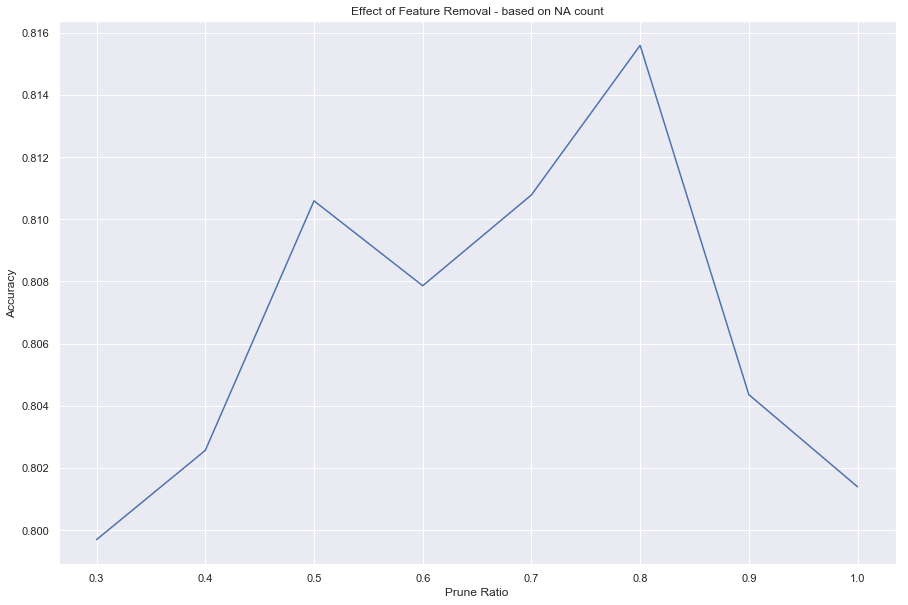

In [181]:
def base_modal_score(prune_ratio=0.8):
    final_pipeline = make_pipeline(get_feature_union(prune_ratio=prune_ratio),base_model)
    final_pipeline.fit(X_train,y_train)
    return final_pipeline.score(X_test,y_test)

prune_ratio_range = np.arange(0.3,1.1,0.1)
prune_score = [base_modal_score(p) for p in prune_ratio_range]

plt.figure(figsize=(15,10))
sns.lineplot(prune_ratio_range,prune_score)
plt.title("Effect of Feature Removal - based on NA count")
plt.xlabel("Prune Ratio")
plt.ylabel("Accuracy")

### Creating our Final Pipeline 

+ Here, 0 implies removing all features, and 1 implies removing no feature.
+ As we can see 0.80 as prune ratio gives us the best accuracy
+ Which implies that we remove columns which has NA count greater then 80%.
----

##### Note: The Ratio does vary depending upon the train-test split sometimes. But its recommended to remove feature with NA count greater then 80-85%, if possible with creation of another feature denoting presence and absence of value. Solutions vary with dataset. 

In [188]:
_max_accurcy_idx = np.argmax(prune_score)
_best_ratio = prune_ratio_range[_max_accurcy_idx]
final_pipeline = make_pipeline(get_feature_union(_best_ratio),base_model)

### Hyper parameter optimization

+ For Tunning hyper parameters for our Random Forest we will use RandomizedSearchCV
+ The parameters that we will tune on are:
    - Depth
    - Maximum samples for leaf
    - Maximum nodes


In [191]:
max_depth = np.ceil(np.log2(train_data.shape[0]))

min_depth = np.floor(max_depth/2)

param_tune = {
             'randomforestregressor__max_features': ['auto','sqrt','log2'],
             'randomforestregressor__max_leaf_nodes':[400,800,1200,],
             'randomforestregressor__max_depth':np.arange(min_depth,max_depth),
             'randomforestregressor__min_samples_leaf':np.arange(1,10)}

rs = RandomizedSearchCV(final_pipeline,param_tune,n_jobs=-1,cv=5,verbose=10)

rs.fit(X_train,y_train)

print(rs.best_estimator_.score(X_test,y_test))
print(rs.best_score_)


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:   23.8s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   33.0s
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.3min finished


0.8088913735533706
0.8036258699291169


### Validation Curve for Random Forest

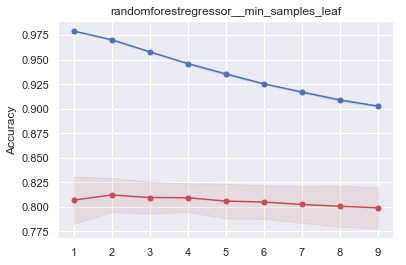

<Figure size 720x720 with 0 Axes>

In [194]:
p_name = 'randomforestregressor__min_samples_leaf'

p_range = np.arange(1,10)


from matplotlib import pyplot as plt

def plot_validation_curve(estimator,p_name,p_range,ax,x,y):
    """
        plots validation curve against specified parameters values using validation_curve by sklearn.
        
        parameters:
        -----------
        estimator(Estimator) - sklearn estimator instance which has fit, predict and score methods
        param_name(str) -  estimator parameter name
        param_range(list of values) - estimator parameter range
        ax - matplotlib's axes
        x(DataFrame or numpy array) - training data
        y(DataFrame or numpy array) - correct outputs
    """
    train_scores,test_scores = validation_curve(
                                    estimator,
                                    X = x, y = y, 
                                    param_name = p_name, 
                                    param_range = p_range,cv=3,n_jobs=-1)
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    test_mean = np.mean(test_scores, axis=1)
    test_std = np.std(test_scores, axis=1)
    plt.figure(figsize=(10,10))

    ax.plot(p_range,train_mean,color='b',marker='o',markersize=5)
    ax.fill_between(p_range,
                     train_mean+train_std,
                     train_mean-train_std,
                     color='b',alpha=0.1)


    ax.plot(p_range,test_mean,color='r',marker='o',markersize=5)
    ax.fill_between(p_range,
                     test_mean+test_std,
                     test_mean-test_std,
                     color='r',alpha=0.1)
    
    ax.set_title(p_name)
    ax.set_ylabel("Accuracy")

plot_validation_curve(final_pipeline,p_name,p_range,plt.gca(),train_data,output_y)

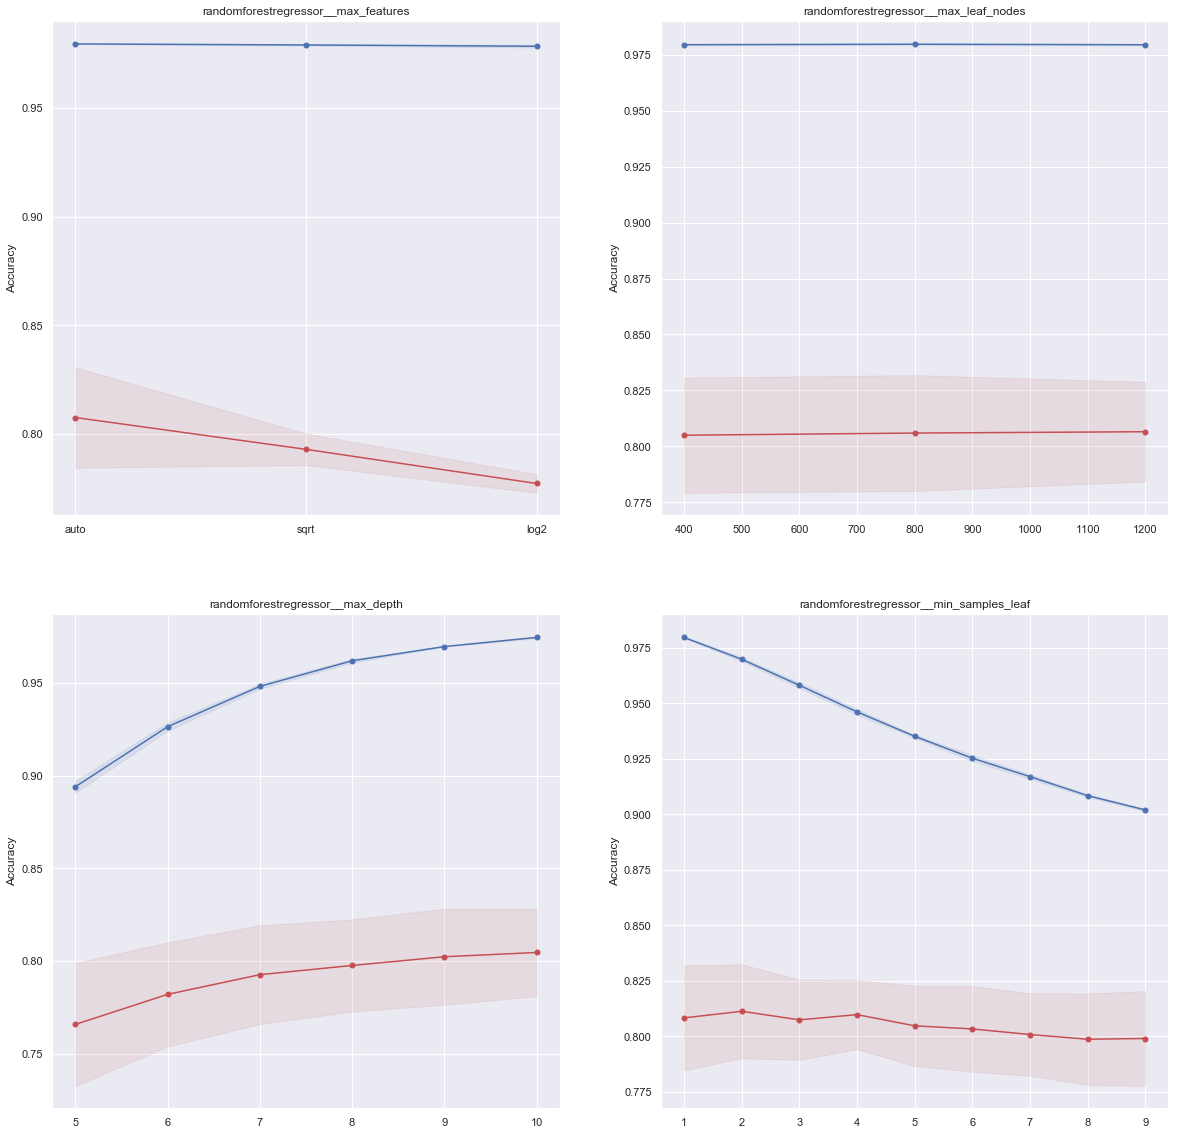

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

In [195]:
fig,axs = plt.subplots(2,2,figsize=(20,20))
for key,ax in zip(param_tune.keys(),axs.flatten()):
    plot_validation_curve(final_pipeline,key,param_tune[key],ax,train_data,output_y)
    